In [13]:
import os 
os.chdir('../src/')
print(os.getcwd())
from traffic_analysis.d05_evaluation.chunk_evaluator import ChunkEvaluator
from traffic_analysis.d00_utils.load_confs import load_parameters
from traffic_viz.d06_visualisation.chunk_evaluation_plotting import (
    plot_video_stats_diff_distribution,
    plot_video_level_summary_stats,
    plot_mAP_over_time)

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
params = load_parameters()
pd.set_option('display.max_columns', 500)

%matplotlib inline

C:\Users\Caroline Wang\OneDrive\DSSG\air_pollution_estimation\src


Read in video level data

In [2]:
xml_paths = ["C:\\Users\\Caroline Wang\\OneDrive\\DSSG\\air_pollution_estimation\\annotations\\15_2019-06-29_13-01-03.094068_00001.01252.xml",
            "C:\\Users\\Caroline Wang\\OneDrive\\DSSG\\air_pollution_estimation\\annotations\\14_2019-06-29_13-01-19.744908_00001.05900.xml"]

video_level_df = pd.read_csv("../data/carolinetemp/video_level_df.csv",
                    dtype={"camera_id": str},
                    parse_dates=["video_upload_datetime"])
del video_level_df['Unnamed: 0']

Read in frame level data

In [3]:
frame_level_df = pd.read_csv("../data/carolinetemp/frame_level_df.csv",
                    dtype={"camera_id": str},
                    converters={"bboxes": lambda x: [float(coord) for coord in x.strip("[]").split(", ")]}, 
                    parse_dates=["video_upload_datetime"])
del frame_level_df['Unnamed: 0']

Run evaluators

In [4]:
chunk_evaluator = ChunkEvaluator(annotation_xml_paths=xml_paths,
                                 params=params,
                                 video_level_df=video_level_df,
                                 frame_level_df = frame_level_df)
video_level_stats_df, video_level_diff_df = chunk_evaluator.evaluate_video_level()
frame_level_mAP_df = chunk_evaluator.evaluate_frame_level()

C:\Users\Caroline Wang\OneDrive\DSSG\air_pollution_estimation\src\traffic_analysis\d05_evaluation\video_level_evaluator.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  'n_videos': 'count'})
C:\Users\Caroline Wang\Anaconda3\envs\dssg\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Read in data generated by ec2

In [19]:
video_level_stats_df = pd.read_csv("../data/carolinetemp/eval_video_performance_kcf.csv")
video_level_diff_df = pd.read_csv("../data/carolinetemp/eval_video_diffs_kcf.csv")

# video_level_stats_df = pd.read_csv("../data/carolinetemp/eval_video_performance_csrt.csv")
# video_level_diff_df = pd.read_csv("../data/carolinetemp/eval_video_diffs_csrt.csv")

In [7]:
video_level_stats_df

,vehicle_type,stat,bias,mae,rmse,sd,n_videos,creation_datetime,analyser_type
0,bus,counts,-0.333333,0.583333,0.957427,0.916831,24,2019-08-08 18:06:14.581466,trackinganalyser_kcf
1,bus,starts,0.000000,0.000000,0.000000,0.000000,24,2019-08-08 18:06:14.581466,trackinganalyser_kcf
2,bus,stops,-0.041667,0.125000,0.353553,0.358641,24,2019-08-08 18:06:14.581466,trackinganalyser_kcf
3,car,counts,9.750000,10.000000,14.393285,10.815649,24,2019-08-08 18:06:14.581466,trackinganalyser_kcf
4,car,starts,0.791667,0.791667,1.567907,1.382473,24,2019-08-08 18:06:14.581466,trackinganalyser_kcf
5,car,stops,11.958333,11.958333,15.886315,10.683100,24,2019-08-08 18:06:14.581466,trackinganalyser_kcf
6,motorbike,counts,-0.541667,0.541667,0.978945,0.832971,24,2019-08-08 18:06:14.581466,trackinganalyser_kcf
7,motorbike,starts,0.000000,0.000000,0.000000,0.000000,24,2019-08-08 18:06:14.581466,trackinganalyser_kcf
8,motorbike,stops,0.000000,0.000000,0.000000,0.000000,24,2019-08-08 18:06:14.581466,trackinganalyser_kcf
9,truck,counts,-0.375000,0.625000,1.207615,1.172604,24,2019-08-08 18:06:14.581466,trackinganalyser_kcf


In [17]:
def plot_video_level_summary_stats(video_level_stats_df: pd.DataFrame, 
                                   metrics = {'bias':None, 'rmse':None, 'mae': None},
                                   show_plots = True): 
    """For each error metric specified, will plot a multi-bar bar chart with bars 
    for each vehicle type and stats type.

    Args: 
        video_level_stats_df: output of ChunkEvaluator.aggregate_video_stats_all_vehicle_types()
        metrics: dictionary where the metric type is the key and the value is the desired save path
        show_plots: If true, will display the plots 
    """
    assert set(metrics.keys()).issubset(set(['bias', 'rmse', 'mae'])), \
        "Only the following metrics types are supported: bias, rmse, mae"
    n_videos = video_level_stats_df['n_videos'].iloc[0]
    
    def style_show_save_plot(metric_type):
        ax.set_facecolor('whitesmoke')

        for side in ax.spines:
            ax.spines[side].set_visible(False)

        plt.title(f"Video level performance on {n_videos} videos")
        plt.xticks(rotation=45)
        plt.xlabel("Vehicle Type", labelpad=20)
        plt.ylabel(metric_type)
        plt.ylim(ymax = 25, ymin = 0)
        plt.subplots_adjust(bottom=0.25)

        if metrics[metric_type] is not None: 
            plt.savefig(metrics[metric_type])
        if show_plots: 
            plt.show()
        plt.close()
    
    if 'bias' in metrics: 
        bias_df = (video_level_stats_df[['stat','vehicle_type', 'bias']]
                    .pivot(index='vehicle_type', columns='stat', values='bias'))
        sd_df = (video_level_stats_df[['stat','vehicle_type', 'sd']]
                    .pivot(index='vehicle_type', columns='stat', values='sd')
                    .values.T)

        ax = bias_df.plot(kind='bar',
                            yerr=sd_df,
                            grid=False,
                            figsize=(12,10),
                            position=0.45,
                            colormap = 'Paired',
                            error_kw=dict(ecolor='k',elinewidth=0.5),
                            width=1.0
                            )
        style_show_save_plot(metric_type = 'bias')
        
    if 'mae' in metrics: 
        mae_df = (video_level_stats_df[['stat','vehicle_type', 'mae']]
                    .pivot(index='vehicle_type', columns='stat', values='mae'))
        sd_df = (video_level_stats_df[['stat','vehicle_type', 'sd']]
                    .pivot(index='vehicle_type', columns='stat', values='sd')
                    .values.T)
        ax = mae_df.plot(kind='bar',
                            yerr=sd_df,
                            grid=False,
                            figsize=(12,10),
                            position=0.45,
                            colormap = 'Paired',
                            error_kw=dict(ecolor='k',elinewidth=0.5),
                            width=1.0
                            )

        style_show_save_plot(metric_type = 'mae')
        
    if 'rmse' in metrics: 
        rmse_df = (video_level_stats_df[['stat','vehicle_type', 'rmse']]
                    .pivot(index='vehicle_type', columns='stat', values='rmse'))

        ax = rmse_df.plot(kind='bar',
                            grid=False,
                            figsize=(12,10),
                            position=0.45,
                            colormap = 'Paired',
                            width=1.0
                            )
        style_show_save_plot(metric_type='rmse')


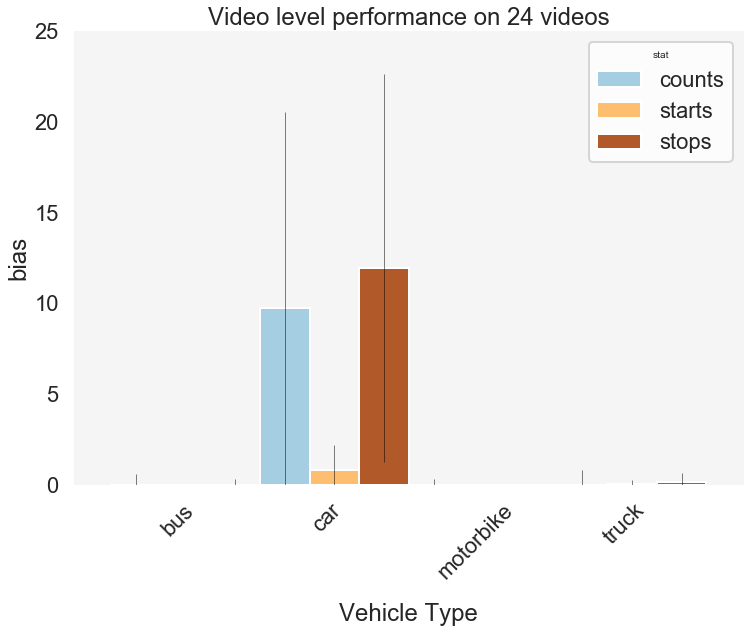

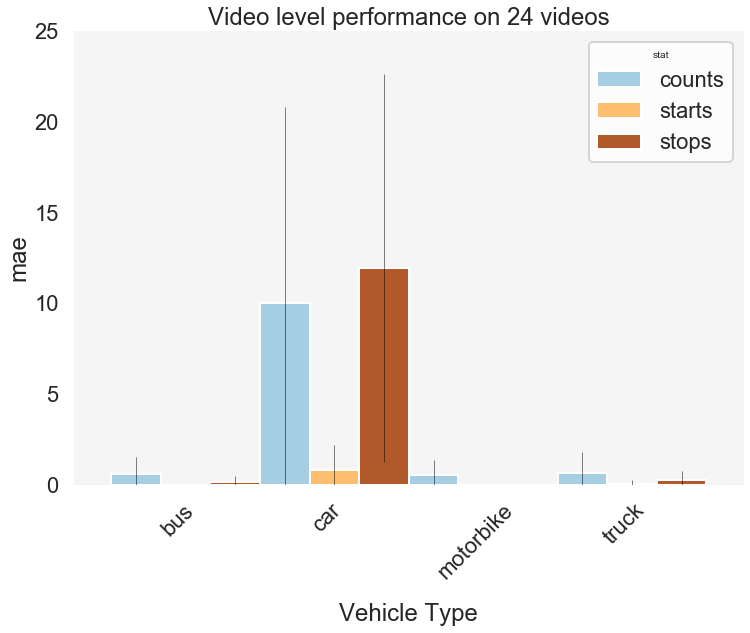

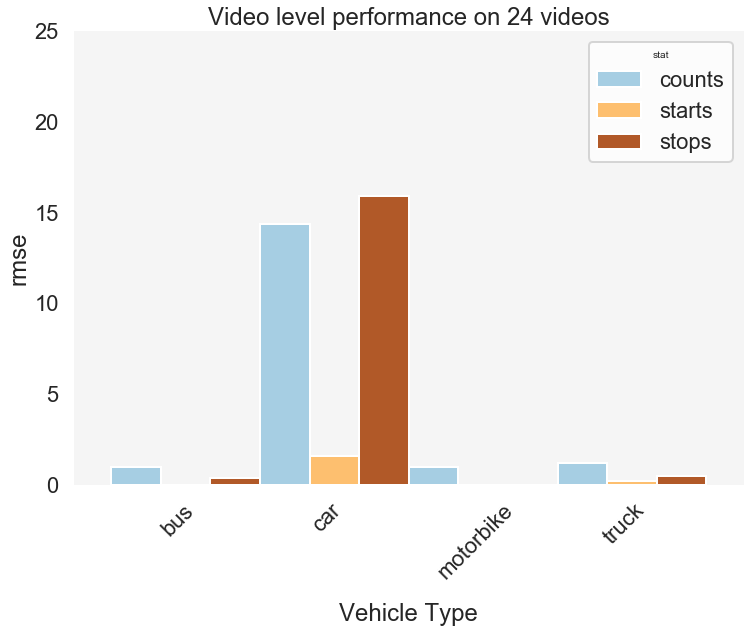

In [21]:
plot_video_level_summary_stats(video_level_stats_df, 
                       metrics = {'bias':"../data/plots/video_bias_kcf.pdf",
                                  'rmse':"../data/plots/video_rmse_kcf.pdf",
                                   'mae': "../data/plots/video_mae_kcf.pdf"})

Plot video level diffs

In [4]:
video_level_diff_df

,camera_id,video_upload_datetime,vehicle_type,count_true,starts_true,stops_true,counts_pred,starts_pred,stops_pred,counts_diff,starts_diff,stops_diff,creation_datetime,analyser_type
0,1.01252,2019-06-20 06:00:46,car,4,0,1,14,2,12,10,2,11,2019-08-08 18:06:14.620952,trackinganalyser_kcf
1,1.01252,2019-06-20 06:00:46,truck,0,0,0,0,0,0,0,0,0,2019-08-08 18:06:14.620952,trackinganalyser_kcf
2,1.01252,2019-06-20 06:00:46,bus,1,0,0,0,0,0,-1,0,0,2019-08-08 18:06:14.620952,trackinganalyser_kcf
3,1.01252,2019-06-20 06:00:46,motorbike,3,0,0,0,0,0,-3,0,0,2019-08-08 18:06:14.620952,trackinganalyser_kcf
4,1.01252,2019-06-20 05:58:17,car,1,0,0,1,0,1,0,0,1,2019-08-08 18:06:14.620952,trackinganalyser_kcf
5,1.01252,2019-06-20 05:58:17,truck,0,0,0,0,0,0,0,0,0,2019-08-08 18:06:14.620952,trackinganalyser_kcf
6,1.01252,2019-06-20 05:58:17,bus,2,0,1,0,0,0,-2,0,-1,2019-08-08 18:06:14.620952,trackinganalyser_kcf
7,1.01252,2019-06-20 05:58:17,motorbike,2,0,0,0,0,0,-2,0,0,2019-08-08 18:06:14.620952,trackinganalyser_kcf
8,1.03601,2019-06-20 08:58:01,car,5,0,1,39,2,27,34,2,26,2019-08-08 18:06:14.620952,trackinganalyser_kcf
9,1.03601,2019-06-20 08:58:01,truck,4,0,1,1,0,1,-3,0,0,2019-08-08 18:06:14.620952,trackinganalyser_kcf


In [7]:
def plot_video_stats_diff_distribution(video_level_diff_df: pd.DataFrame,
                                       video_stat_types: list, 
                                       show_plot: bool = True,
                                       save_path: str = None):
    """For each statistic type (counts, starts, stops, etc.) plots the
    distribution of difference from ground truth for each vehicle type

    Args:
        video_level_diff_df: the output of ChunkEvaluator.evaluate_video_level()
        video_stat_types: list of video level stats computed (pass from params)
        show_plot: If true, will display the plot
        save_path: if specified, will save to this location (specify full path with
        desired filename)
    """
    plt.style.use('seaborn-deep')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(30,25))
    
    for i,stat_type in enumerate(video_stat_types):
        stat_list = []
        vehicle_types=[]
        for vehicle_type, vehicle_group_df in video_level_diff_df.groupby("vehicle_type"):
            stat_list.append(vehicle_group_df[f"{stat_type}_diff"])
            vehicle_types.append(vehicle_type)

        # plot distribution of stat_type on one sub-plot
        ax = eval(f"ax{i+1}")
        ax.set_title(stat_type, fontsize = 32)
        ax.hist(x=stat_list, 
                label=vehicle_types,
                alpha=0.8)
        ax.legend(loc="upper right")

    fig.suptitle("Distribution of Differences for Traffic Statistics", size=40)
    fig.text(0, 0.5,"Frequency", ha='center', va='center', rotation='vertical', size=32) #y label
    fig.text(0.5, 0, "Model Prediction", ha='center', va='center', size=32) # x label

    fig.tight_layout()
    fig.subplots_adjust(top=0.90, 
                        left = 0.07,
                        right= 0.85,
                        bottom = 0.07
                       )
    if save_path is not None: 
        plt.savefig(save_path)
    if show_plot: 
        plt.show()
    plt.close()

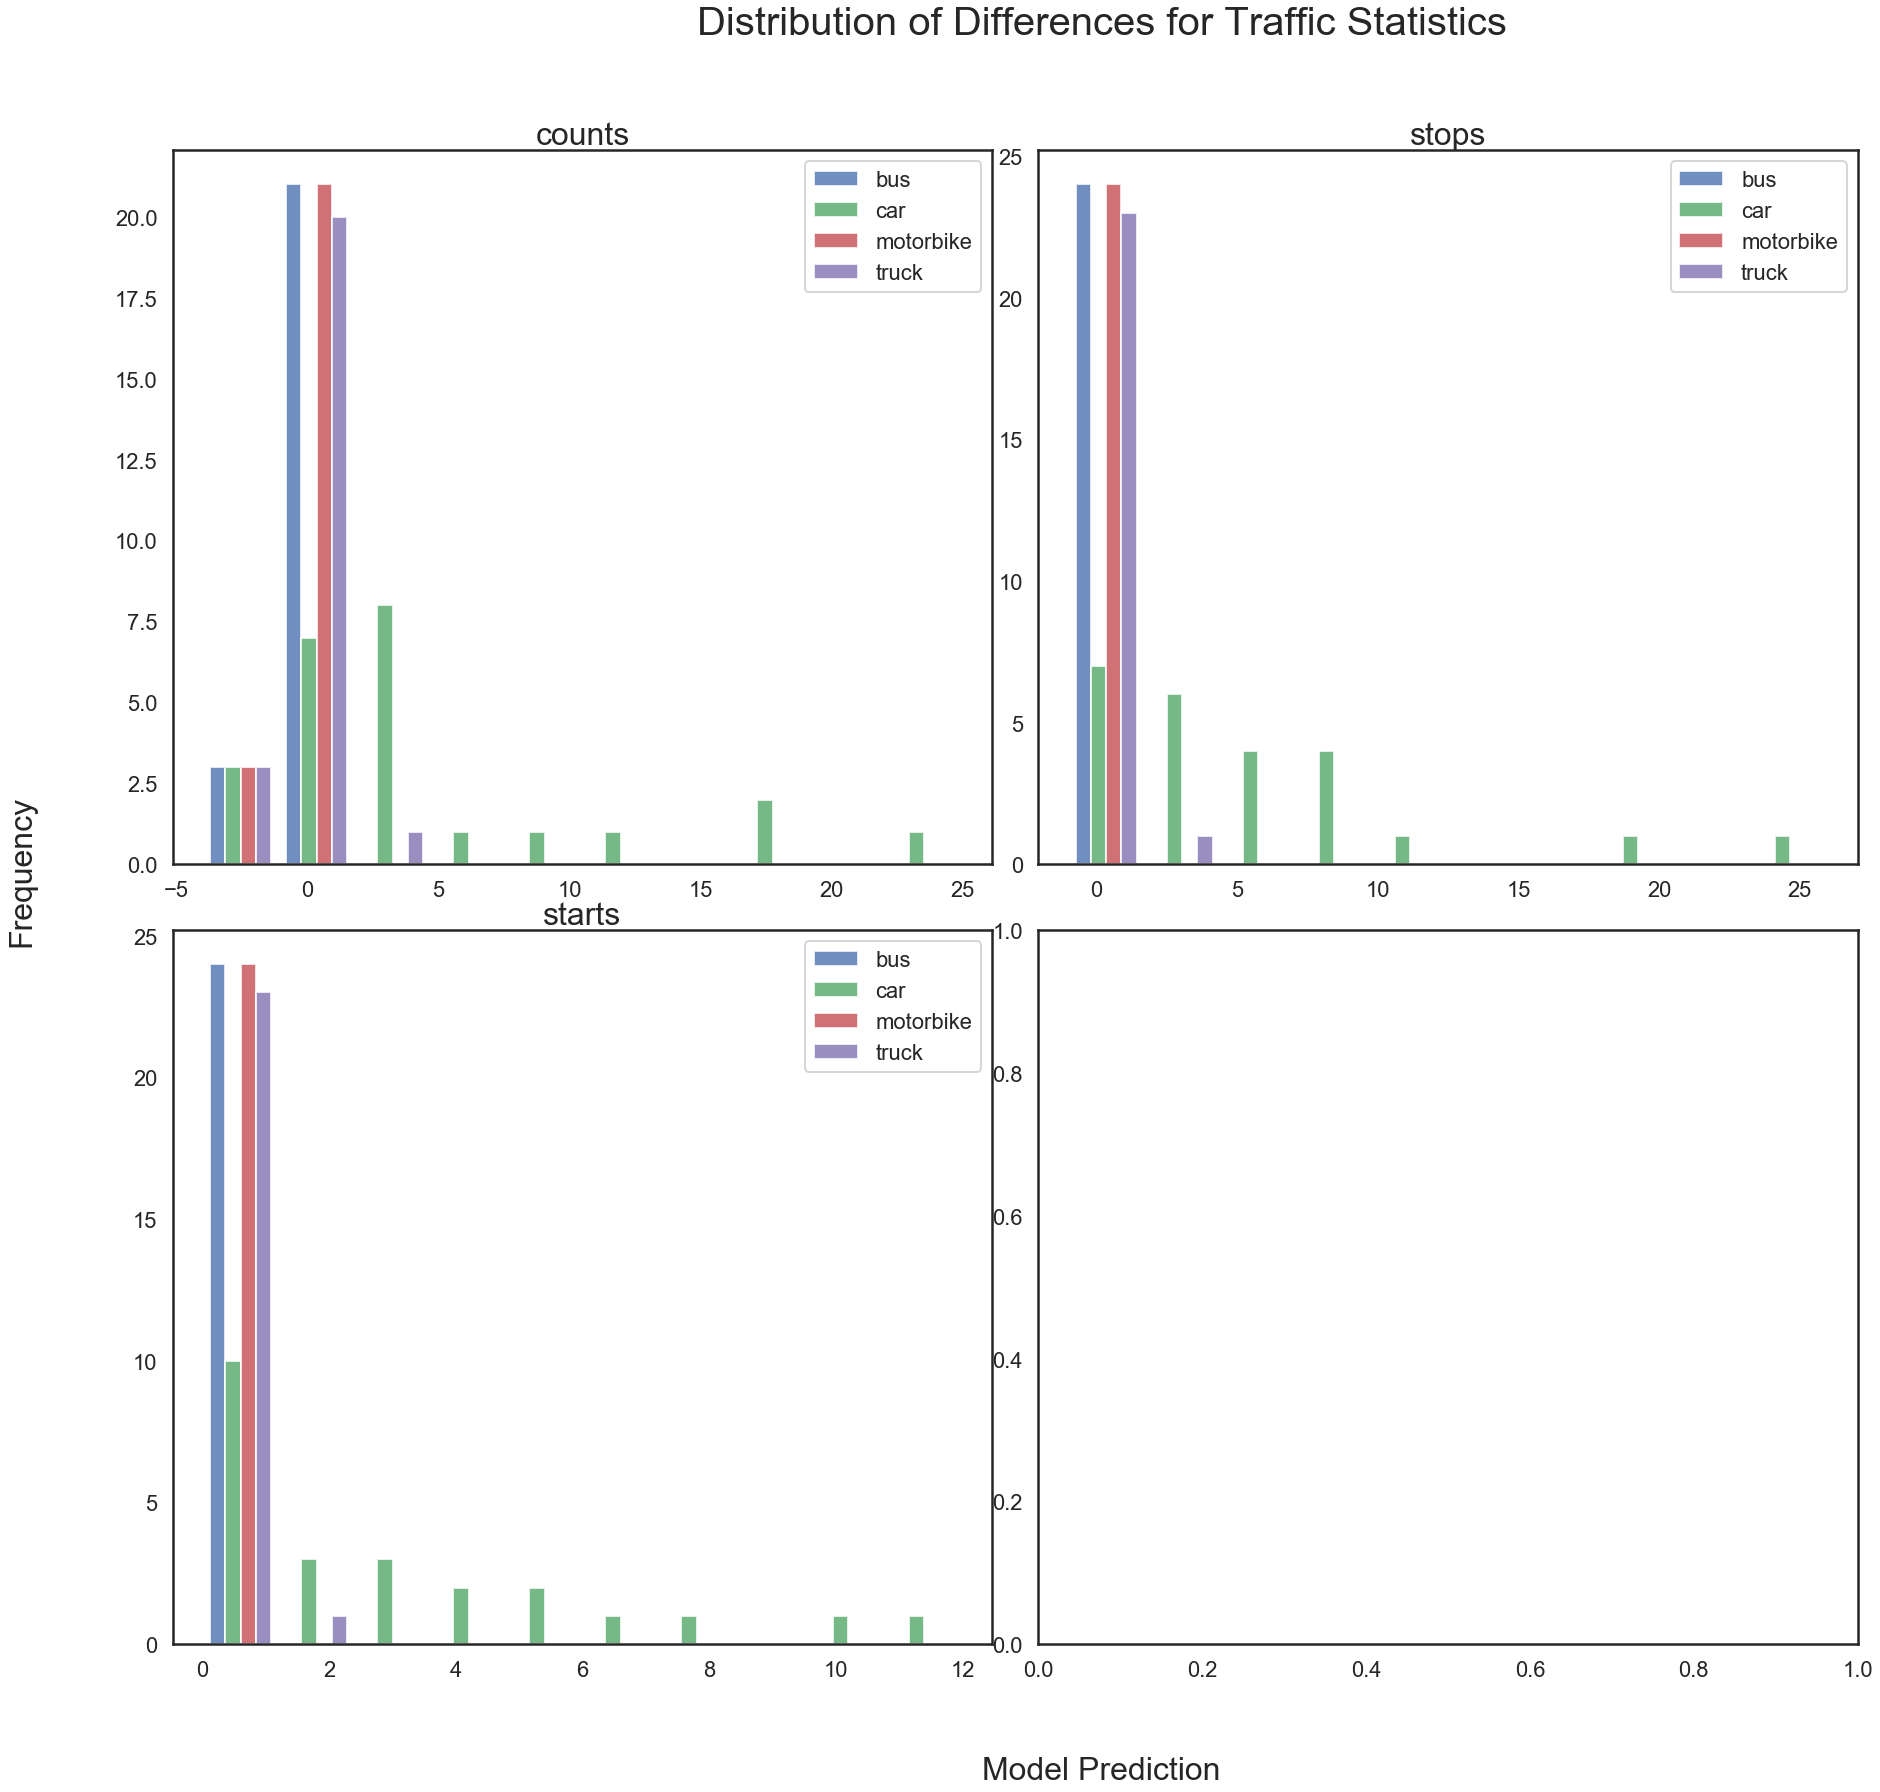

In [12]:
plot_video_stats_diff_distribution(video_level_diff_df,video_stat_types = ["counts", "stops", "starts"],
                                  save_path = "../data/plots/diff_dist_csrt.pdf")

## Frame Level Plotting

In [ ]:
frame_level_mAP_df

In [ ]:
plot_mAP_over_time(frame_level_mAP_df,
                   save_path = "../data/plots/map_over_time.pdf"
                  )